# Agentic RAG implemented using FloAI

FloAI has just made implementing agentic RAG simple and easy to manage. The Diagram shows what we are going to implement:

<div style="text-align: center;">
    <img src="./images/agentic-rag.png" alt="Sample Image" width="1000" height="300"/>
</div>

To implement this we use the following components, already available in flo-ai:

1. `tool` agent: This will be a tool agent to retrieve the records from vector store
2. `delegator` agent: The agent will check if the retrieved records are relevent, else it will re-write the query and send it back for re-retrieval
3. `llm` agent: This will generate the output from the relevant documents

In [ ]:
from flo_ai import Flo
from flo_ai import FloSession
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter

from dotenv import load_dotenv
load_dotenv()

## Setting up Vector Store with Sample Data

Using Chroma is this example

In [ ]:
# load the document and split it into chunks
loader = TextLoader("./data/rag_document.txt")
documents = loader.load()

# split it into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# load it into Chroma
db = Chroma.from_documents(docs, embedding_function)

/Users/vizsatiz/Documents/hub/flo/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/vizsatiz/Documents/hub/flo/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Creating the retrival tool

This tool will retrive the records from vector db

In [3]:
from flo_ai.retrievers.flo_retriever import FloRagBuilder
from flo_ai.retrievers.flo_compression_pipeline import FloCompressionPipeline

llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini')
session = FloSession(llm)
builder = FloRagBuilder(session, db.as_retriever())
compression_pipeline = FloCompressionPipeline(OpenAIEmbeddings(model="text-embedding-3-small"))
compression_pipeline.add_embedding_reduntant_filter()
compression_pipeline.add_embedding_relevant_filter()

retriever_tool = builder.with_compression(compression_pipeline).build_retriever_tool(name="HousingLoanRetreiver",
                                                                                               description="Tool to fetch data around housing loans")
session.register_tool(name="HousingLoanTool", tool=retriever_tool)

2024-09-23 14:42:29,261 - SESSION - INFO - New FloSession created with ID: fb386a6f-07b9-4cf4-a83a-21f322c7289c
2024-09-23 14:42:29,359 - SESSION - INFO - Tool 'HousingLoanTool' registered for session fb386a6f-07b9-4cf4-a83a-21f322c7289c


## Creating the flo

This follow as you can see consist of the following components:

1. HousingLoanRetriver: This is a `tool agent`, with ability to retrieve from vector store
2. RelevancyChecker: This is a `delegator agent` with ability to delegate based on relevancy
3. ResponseGenerator: This is a `llm agent` with ability to response based on documents

2024-09-23 14:45:06,389 - BUILDER - INFO - Building Flo instance from YAML
2024-09-23 14:45:06,398 - COMMON - INFO - Flo instance created for session fb386a6f-07b9-4cf4-a83a-21f322c7289c


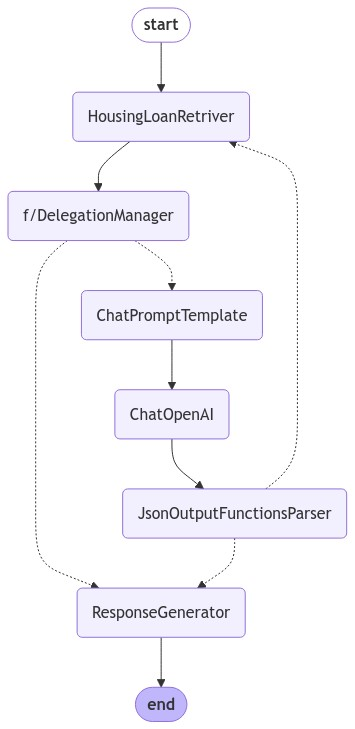

In [8]:
agent_yaml = """
apiVersion: flo/alpha-v1
kind: FloRoutedTeam
name: agentic-rag
team:
    name: AgenticRAGTeam
    router:
        name: SupportSupervisor
        kind: linear
    agents:
      - name: HousingLoanRetriver
        kind: tool
        job: Fetching the loan information from the loan tool
        tools:
          - name: HousingLoanTool
      - name: RelevancyChecker
        kind: delegator
        to:
          - name: HousingLoanRetriver
          - name: ResponseGenerator
        retry: 1
        job: >
          Your job is to check if the records fetched by the retriever are relevent to the question.
          If its not relevant re-write the query send to HousingLoanRetriver for re-retrieval.
          If its relevant then send to ResponseGenerator for response generation
      - name: ResponseGenerator
        kind: llm
        job: Based on the documents given answer the user question that was asked
"""

flo = Flo.build(session, agent_yaml)

flo.draw()

In [9]:
print(flo.invoke("Whats the interest rate for housing loan ?"))

2024-09-23 14:45:11,703 - COMMON - INFO - Invoking query for session fb386a6f-07b9-4cf4-a83a-21f322c7289c: Whats the interest rate for housing loan ?


{'messages': [HumanMessage(content='Whats the interest rate for housing loan ?'), HumanMessage(content='You can use any one of the ways to repay the loan:\n \n  Cheques\n  Standing instructions at your branch\n  FedNet - Internet Banking\n  Automated Payment through ECS\n  Mobile Banking\n\n  Housing loan interest rates will change subject to the changes made by Bank/RBI from time to time. \n\nPresent Repo Rate\t 6.50%  (p.a)\n \n\nLoan scheme\n\nInterest Rate (%) * \n\nHome Loan  \n\n8.80 (Repo Rate+ 2.30) Onwards \n\n*T&C Apply\nHousing Loan\n\nYour dream home is never far away! Get hassle free home loans from Federal Bank to turn your dream home into reality. We assist you to realize your dream home. Avail your Housing Loan from us at competitive interest rates. The loan scheme assists borrowers for construction of house, acquisition of land & construction of house, repairs / renovation / remodeling / extension of house, reimbursement of debt incurred for construction / purchase / f